<div><img src="blob/structure.jpg" width=400px float="left"/></div>

# Svg to text with Transformer

In [1]:
import io
import os
import math
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
from cairosvg import svg2png
import svgwrite
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from sklearn.model_selection import train_test_split

import svg_converter as converter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

In [4]:
# fn_tok_path = 'dataset/filenames_tokenized.txt'

# with open(fn_tok_path, 'w') as f:
#     folder_path = 'dataset'
#     filenames = []
    
#     for root, _, files in os.walk(folder_path):
#         for file in files:
#             filename, extension = os.path.splitext(file)
#             if extension == '.svg':
#                 filenames.append(filename)
            
#     for line in filenames:
#         _, filename = line.strip().split('_')
#         filename = filename.replace('-', ' ')
#         f.write(tokenize(filename) + "\n")

In [5]:
# learn_bpe(open(fn_tok_path), open('bpe_rules.fnt', 'w'),  num_symbols=3000)

In [6]:
filenames_bpe = BPE(open('bpe_rules.fnt'))

In [7]:
def get_svg_paths(folders):
    svg_paths = []

    for i, folder in enumerate(folders):
        files = [file for file in os.listdir(folder)]

        for file in files:
            svg_name = file[:-4] # del ".svg"
            svg_name = svg_name.strip().split('_')

            if len(svg_name) > 1:
                svg_name = svg_name[1]
            else:
                svg_name = svg_name[0]
                
            svg_name = svg_name.replace('-', ' ')
            svg_name = tokenize(svg_name)
            svg_name = filenames_bpe.process_line(svg_name)

            svg_path = os.path.join(folder, file)

            svg_paths.append([svg_name, svg_path])

    return svg_paths

In [8]:
dirname = 'dataset'
folders = os.listdir(dirname)
folders = [os.path.join(dirname, foldername) for foldername in folders if os.path.isdir(os.path.join(dirname, foldername))]

all_svg_paths = np.array(get_svg_paths(folders[:50]))

In [9]:
len(all_svg_paths), all_svg_paths[:5]

(2928,
 array([['fre@@ e@@ dom', 'dataset/4111_womens-day-2/244552_freedom.svg'],
        ['equ@@ ality gender',
         'dataset/4111_womens-day-2/244545_equality-gender.svg'],
        ['a@@ chi@@ e@@ ve@@ ment mountain',
         'dataset/4111_womens-day-2/244542_achievement-mountain.svg'],
        ['education col@@ le@@ ge',
         'dataset/4111_womens-day-2/244551_education-college.svg'],
        ['stop vi@@ o@@ l@@ ence woman',
         'dataset/4111_womens-day-2/244556_stop-violence-woman.svg']],
       dtype='<U123'))

In [10]:
train_paths, test_paths = train_test_split(
    all_svg_paths,
    test_size=0.2,
    random_state=42,
)

In [11]:
len(train_paths), len(test_paths), train_paths[0]

(2342,
 586,
 array(['inbox with document',
        'dataset/350_ios7-premium-fill-2/13445_inbox-with-document.svg'],
       dtype='<U123'))

In [12]:
class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.long, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

In [13]:
voc = Vocab.from_lines(all_svg_paths[:,0])
len(voc)

1548

In [14]:
batch_lines = sorted(train_paths[:,0], key=len)[0:4]
batch_ids = voc.to_matrix(batch_lines)
batch_lines_restored = voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['cd', 'cd', 'at', 'sun']

words to ids (0 = bos, 1 = eos):
tensor([[   0,  232,    1],
        [   0,  232,    1],
        [   0,   78,    1],
        [   0, 1325,    1]])

back to words
['cd', 'cd', 'at', 'sun']


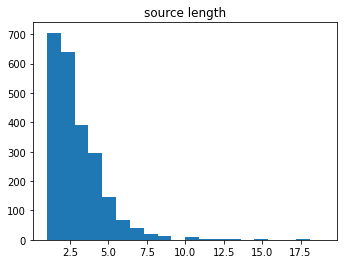

In [15]:
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_paths[:,0]))), bins=20)
plt.show()

In [16]:
def get_tgt_mask(size):
    mask = torch.tril(torch.ones(size, size) == 1)
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))
    return mask

def get_src_pad_mask(matrix, pad_token):
    mask = torch.zeros(matrix.size(0), matrix.size(1))

    pad_positions = (matrix == pad_token).all(dim=-1)
    
    pad_positions = torch.roll(pad_positions, shifts=1, dims=1) 
    pad_positions[:, 0] = 0
    
    mask[pad_positions] = 1
    
    return mask

def show(vec, scale=150):
    svg = c.to_svg(vec, scale=scale)
    display(svg_to_pil(svg))

def svg_to_pil(svg):
    dwg = svgwrite.Drawing(
        '',
        profile='tiny',
        fill_rule="evenodd", 
        size=(f"{svg['width']}px", f"{svg['height']}px")
    )

    dwg.add(
        dwg.path( d=svg['d'].d(),
        fill="#000")
    )
    svg_string = dwg.tostring()
    png_data = svg2png(bytestring=svg_string.encode('utf-8'))
    pil_image = Image.open(io.BytesIO(png_data)) 
    return pil_image

In [17]:
class SvgDataset(Dataset):
    def __init__(self, svg_paths, seq_len, device):
        self.device = device

        self.seq_len = seq_len

        self.svg_paths = svg_paths

        self.converter = converter.Converter(self.seq_len)

    def __len__(self):
        return len(self.svg_paths)

    def load_svg(self, path):
        try:
            _, vector = self.converter.to_vector(self.converter.open(path), is_one_len=True)
            return vector
        
        except Exception as e:
#             print(e)
            return None

    def __getitem__(self, idx):

        svg_name, svg_path = self.svg_paths[idx]
        vector = self.load_svg(svg_path)

        if vector:
            vector = torch.tensor(vector)
            return (
              vector,
              svg_name,
            )
        else:
            while True:
                svg_name, svg_path = random.choice(self.svg_paths)
                vector = self.load_svg(svg_path)

                if vector:
                    vector = torch.tensor(vector)
                    return (
                      vector,
                      svg_name,
                    )

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
    
        pos_encoding = torch.zeros(max_len, dim)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0)) / dim) # 1000^(2i/dim_model)
        
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

    
class Transformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        dim,
        n_heads,
        n_encoder_layers,
        n_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.dim = dim
        
        self.src_encoder = nn.Linear(11, dim)
        
        self.positional_encoder = PositionalEncoding(
            dim=dim, dropout_p=dropout_p, max_len=1000
        )
        
        self.embedding = nn.Embedding(vocab_size, dim)
        
        self.transformer = nn.Transformer(
            d_model=dim,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )
        
        self.out = nn.Linear(dim, vocab_size)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        
        src = self.src_encoder(src)
        tgt = self.embedding(tgt) * math.sqrt(self.dim)
        
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        transformer_out = self.transformer(
            src, tgt, 
            tgt_mask=tgt_mask, 
            src_key_padding_mask=src_pad_mask, 
            tgt_key_padding_mask=tgt_pad_mask
        )
        
        out = self.out(transformer_out)
        
        return out

In [19]:
batch_size = 32
seq_len = 256
src_pad_token = torch.tensor([0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000])

c = converter.Converter(seq_len)

train_dataset = SvgDataset(train_paths, seq_len=seq_len, device=device)
test_dataset = SvgDataset(test_paths, seq_len=seq_len, device=device)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

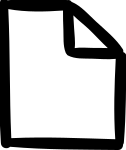

letter


In [42]:
for vec, tgt in train_dl:
    show(vec[0])
    print(tgt[0])
    break

In [43]:
vocab_size = len(voc)
src_pad_token = torch.tensor([0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000])

model = Transformer(
    vocab_size=vocab_size,
    dim=32,
    n_heads=8,
    n_encoder_layers=2,
    n_decoder_layers=2,
    dropout_p=0.1
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

In [45]:
step = -1
metrics = {'train_loss': [], 'test_loss': []}
save_path = "checkpoints"

def plot_metrics(metrics):
    plt.figure(figsize=(12,4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()

def load_checkpoint(save_path, name, version):
    checkpoint = torch.load(f'{save_path}/checkpoint_{name}_{version}.pth')
    
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    
    step = checkpoint['step'] + 1
    metrics = {'train_loss': [], 'test_loss': []}
    
    return step, metrics

def save_checkpoint(save_path, name, version, model, opt, loss):
    torch.save({
      'step': step,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': opt.state_dict(),
      'loss': loss
    }, f'{save_path}/checkpoint_{name}_{version}.pth')

# step, metrics = load_checkpoint(save_path, 'epoch', 5_000)

Epoch: 0, step: 40, loss: 5.101363182067871, test_loss: 4.67893648147583


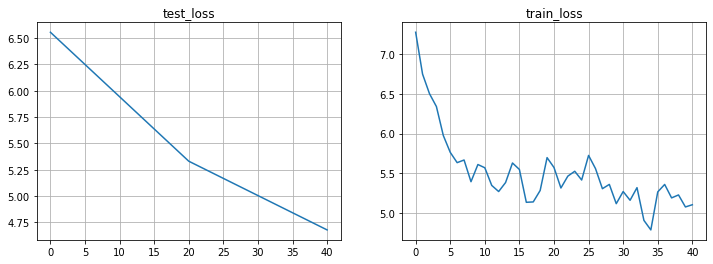

KeyboardInterrupt: 

In [46]:
for epoch in range(10_000):
    for vec, tgt in train_dl:
        model.train()
        step += 1

        vec = vec.to(device)
        tgt = voc.to_matrix(tgt).to(device)
        
        tgt_input = tgt[:,:-1]
        tgt_expected = tgt[:,1:]
        
        src_pad_mask = get_src_pad_mask(vec, src_pad_token)

        tgt_pad_mask = ~voc.compute_mask(tgt_input)
        tgt_mask = get_tgt_mask(tgt_input.size(1)).to(device)

        out = model(vec, tgt_input,
                     tgt_mask=tgt_mask,
                     src_pad_mask=src_pad_mask,
                     tgt_pad_mask=tgt_pad_mask)
        
        out = out.permute(0, 2, 1)

        loss = loss_fn(out, tgt_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        metrics['train_loss'].append((step, loss.item()))
        
        if step%1000 == 0:
            save_checkpoint(save_path,
                            'epoch',
                            f'{step}',
                            model,
                            opt,
                            loss.item())
            
        if step%20 == 0:
            model.eval()
            clear_output()

            for vec, tgt in test_dl:
                vec = vec.to(device)
                tgt = voc.to_matrix(tgt).to(device)

                tgt_input = tgt[:,:-1]
                tgt_expected = tgt[:,1:]

                src_pad_mask = get_src_pad_mask(vec, src_pad_token)

                tgt_pad_mask = ~voc.compute_mask(tgt_input)
                tgt_mask = get_tgt_mask(tgt_input.size(1)).to(device)

                out = model(vec, tgt_input,
                             tgt_mask=tgt_mask,
                             src_pad_mask=src_pad_mask,
                             tgt_pad_mask=tgt_pad_mask)
                
                out = out.permute(0, 2, 1)
                

                test_loss = loss_fn(out, tgt_expected)
                
                break


            metrics['test_loss'].append((step, test_loss.item()))
            
            print(f'Epoch: {epoch}, step: {step}, loss: {loss.item()}, test_loss: {test_loss.item()}')
            plot_metrics(metrics)

In [47]:
def sample_top_p(probs, p):
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token = torch.multinomial(probs_sort, num_samples=1)
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

def predict(model, input_sequence, voc, max_length=15):
    model.eval()
    
    y_input = torch.tensor([[voc.bos_ix]], dtype=torch.long, device=device)

    for _ in range(max_length):
        tgt_mask = get_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence, y_input, tgt_mask)
        
        pred = F.softmax(pred, dim=2)

        sp = sample_top_p(pred[0][-1], 0.8)

        next_item = sp.unsqueeze(0).to(device)

        y_input = torch.cat((y_input, next_item), dim=1)

        if next_item.view(-1).item() == voc.eos_ix:
            break
    
    y_input = voc.to_lines(y_input)

    return y_input

def decode_bpe(encoded_sentence):
    return encoded_sentence.replace("@@ ", "").replace("@@", "").strip()

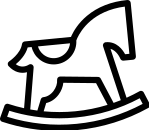

['ds rings off@@ mortarboard il@@ suitcase cros@@']
ds rings offmortarboard ilsuitcase cros


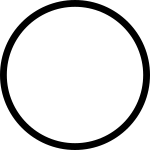

['ct temperature arm mall mo@@ met car art@@ scan ness brain she@@ hot in@@ lding']
ct temperature arm mall momet car artscan ness brain shehot inlding


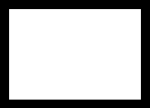

['dro@@ cti@@ envelope and@@ dress beh@@ ray dropper scan mer@@ snow@@ ist fire@@ o@@']
droctienvelope anddress behray dropper scan mersnowist fireo


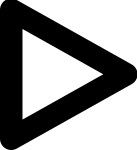

['sign@@ pic@@ ran@@ side pause ent equipment expand mountain document document gla@@ amusement o@@ connection']
signpicranside pause ent equipment expand mountain document document glaamusement oconnection


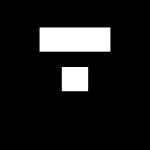

['ness soda se']
ness soda se


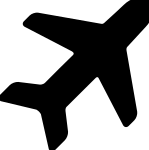

['apart@@ red stand square graph art@@ mat@@ arrows mize ght@@ garden@@ music dro@@ pat@@ badge']
apartred stand square graph artmatarrows mize ghtgardenmusic dropatbadge


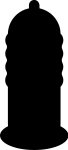

['es gre@@ gam@@ fashion tre@@ tification ver@@ x@@ lder ju@@ angry ca@@ ray']
es gregamfashion tretification verxlder juangry caray


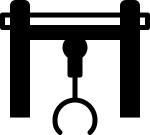

['ust']
ust


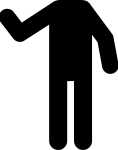

['ent to fro@@ comb eject sun en@@ bank un@@ piggy arrows bowling view dai@@ strip']
ent to frocomb eject sun enbank unpiggy arrows bowling view daistrip


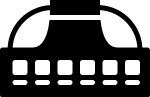

['er@@ rose label l@@ temper@@ sco@@ expand outline dro@@ shuffle iti@@ but@@ buttons ki@@ youtube']
errose label ltemperscoexpand outline droshuffle itibutbuttons kiyoutube


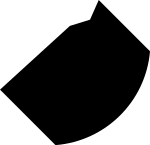

['']



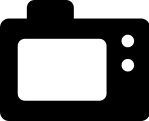

['ding flowers dress black']
ding flowers dress black


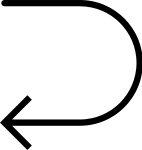

['pills board brow@@ clipboard power acce@@ apart@@ buildings instrument er@@ stick 3 brow@@ employe@@ ple']
pills board browclipboard power acceapartbuildings instrument erstick 3 browemployeple


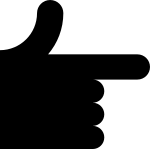

['iling off@@ cookie ve@@ pin@@ ba@@ tho@@ log black headset fireworks two in@@ multi@@ ate']
iling offcookie vepinbatholog black headset fireworks two inmultiate


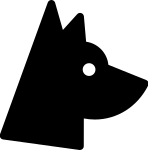

['bed und@@ slee@@ ba@@ pil@@ man@@ de@@ li@@ tw@@ cat@@ ill@@ sa dre@@ sham@@ scar@@']
bed undsleebapilmandelitwcatillsa dreshamscar


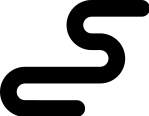

['button r@@ mill ys@@ ated ness hours double thermometer status brain architecture']
button rmill ysated ness hours double thermometer status brain architecture


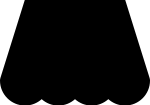

['lin@@ ran@@ airplane ornament fro@@ ves cli@@ settings price twitter bone rain estate cro@@ onal']
linranairplane ornament froves clisettings price twitter bone rain estate croonal


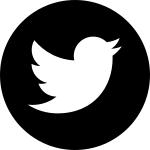

['k@@ gam@@ the cutting mortarboard ition door center ds wind burger cctv candy equ@@ ap@@']
kgamthe cutting mortarboard ition door center ds wind burger cctv candy equap


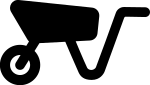

['ld@@ sh tal t@@ on@@ sand tho@@ spray end@@ tation download 3 the ski@@ garden@@']
ldsh tal tonsand thospray endtation download 3 the skigarden


In [48]:
for vec, tgt in test_dl:
    show(vec[:1][0])
    result = predict(model, vec[:1], voc)
    print(result)
    result = decode_bpe(result[0])
    print(result)
